#Introduction

In this notebook, we are tuning parameters of a model containing a bidirectional lstm of 256 units, and an attention mechanism layer (plus pooling and dense). In this case the activation of the attention layer are sigmoids.
Since one of our firsts attempt returned good results with window of 90 and stride of 5, we tried also to set the same sizes here. With this, we reached a score of 4,435, one of our best results up to now.

# Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/MyDrive/Documenti/Università/Magistrale/SecondoAnno/PrimoSemestre/AN2DL/Challenge2

/gdrive/MyDrive/Documenti/Università/Magistrale/SecondoAnno/PrimoSemestre/AN2DL/Challenge2


In [ ]:
!pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.50.0-py3-none-any.whl size=19414 sha256=01d00a335de3808436137304909828c9d0e24259709143e5a0c487ed62a09c5f
  Stored in directory: /root/.cache/pip/wheels/92/7a/a3/231bef5803298e7ec1815215bc0613239cb1e9c03c57b13c14
Successfully built keras-self-attention


# Import libraries

In [ ]:
title = 'Attention_win90st5' #used to save models and checkpoint. Assumes in the current folder, you have a folder called "Models"

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention

warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Exploration Data Analysis (EDA)


Load the dataset

In [ ]:
dataset = pd.read_csv('Dataset/Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


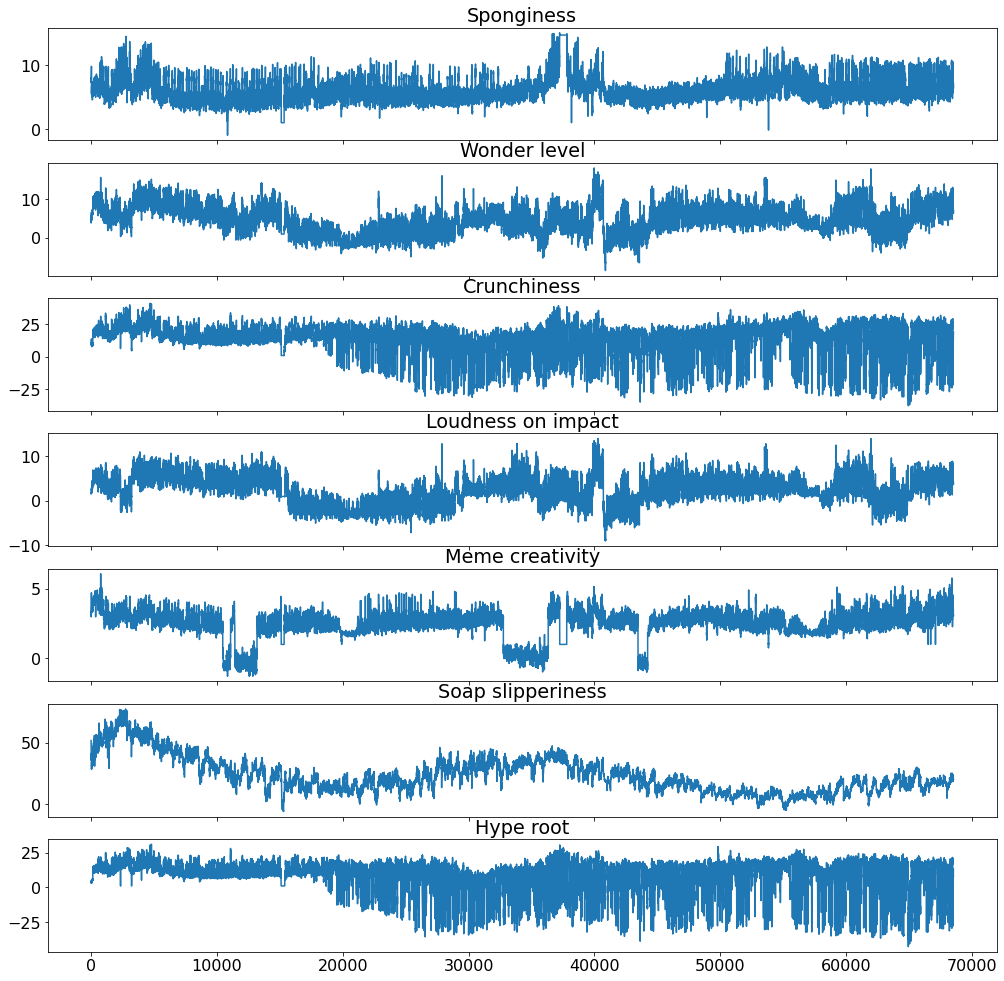

In [ ]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

Sequential Train-Test split and normalization

In [ ]:
print((dataset.shape))

(68528, 7)


(63528, 7) (5000, 7)


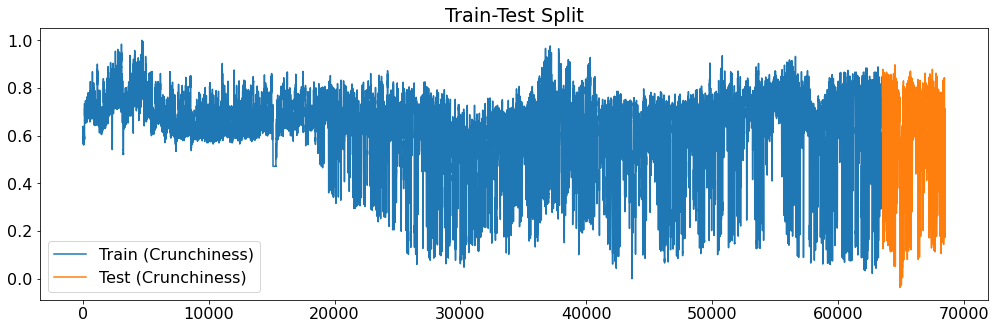

In [ ]:
test_size = 5000
X_train_raw = dataset.iloc[:-test_size]
# y_train_raw = y.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]

# y_test_raw = y.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Crunchiness, label='Train (Crunchiness)')
plt.plot(X_test_raw.Crunchiness, label='Test (Crunchiness)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [ ]:
print('X_min')
print(X_min)
print('X_max')
print(X_max)

X_min
Sponginess            -0.972080
Wonder level          -8.450380
Crunchiness          -34.802881
Loudness on impact    -9.028060
Meme creativity       -1.275860
Soap slipperiness     -6.006860
Hype root            -38.816760
dtype: float64
X_max
Sponginess            15.106680
Wonder level          18.122899
Crunchiness           41.138801
Loudness on impact    14.035980
Meme creativity        6.056360
Soap slipperiness     77.371620
Hype root             31.024420
dtype: float64


In [ ]:
direct_window = 90
direct_stride = 5
ar_window = 90
ar_stride = 5
general_telescope = 864

In [ ]:
future = dataset[-direct_window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
print(future.shape)

(1, 90, 7)


In [ ]:
def build_sequences(df, target_labels=['Sponginess'], window=200, stride=20, telescope=864):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

# Utility functions

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('Check')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_rmse', mode='min', patience=30, restore_best_weights=True),
  callbacks.append(es_callback)
  es2_callback = tfk.callbacks.ReduceLROnPlateau(monitor='val_rmse', mode='min', patience=5, factor=0.5, min_lr=1e-5)
  callbacks.append(es2_callback)

  return callbacks

In [ ]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [ ]:
def build_LSTM_model(input_shape, output_shape):
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    lstm = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(input_layer)
    print(lstm.shape)
    attention = SeqSelfAttention(attention_activation='sigmoid')(lstm)
    print(attention.shape)
    gap = tfkl.GlobalAveragePooling1D()(attention)
    dense = tfkl.Dense(output_shape[0]*output_shape[1], activation='relu')(gap)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    # Connect input and output through the Model class
    full_model = tfk.Model(inputs=input_layer, outputs=output_layer)
    # Compile the model
    full_model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])

    # Return the model
    return full_model

# Forecasting

In [ ]:
target_labels = dataset.columns
telescope = 864

In [ ]:
X_train, y_train = build_sequences(X_train_raw, target_labels, ar_window, ar_stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, ar_window, ar_stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12518, 90, 7), (12518, 864, 7), (818, 90, 7), (818, 864, 7))

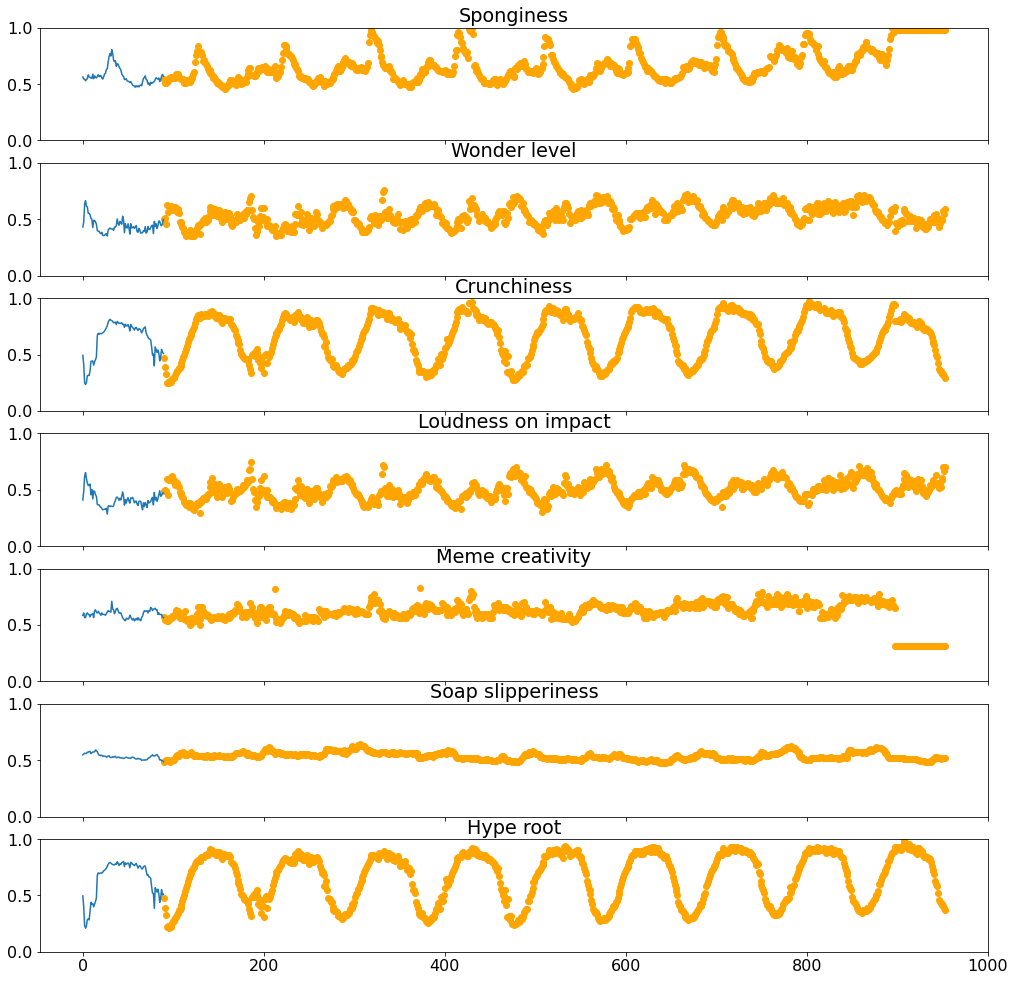

In [ ]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 8
epochs = 500

In [ ]:
print(input_shape, output_shape)

(90, 7) (864, 7)


(None, 90, 512)
(None, 90, 512)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 90, 7)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 90, 512)          540672    
 l)                                                              
                                                                 
 seq_self_attention (SeqSelf  (None, 90, 512)          32833     
 Attention)                                                      
                                                                 
 global_average_pooling1d (G  (None, 512)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6048)              3102624   
                             

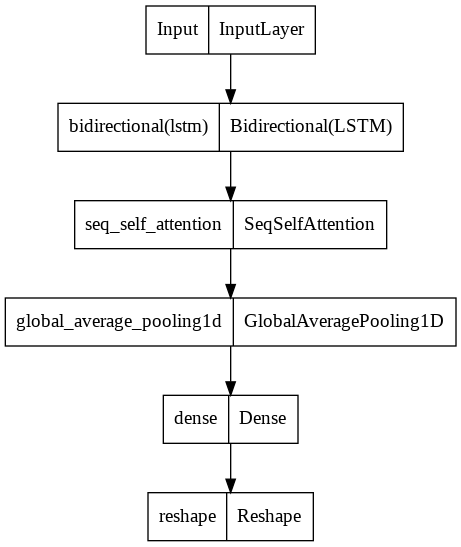

In [ ]:
model = build_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

# Training and testing

In [ ]:
# Create folders and callbacks and fit
cbs = create_folders_and_callbacks(model_name = title) #the model name will generate the folder of this single experiment

# restore checkpoints:
#model.load_weights('/gdrive/MyDrive/Documenti/Università/Magistrale/SecondoAnno/PrimoSemestre/AN2DL/Challenge2/Check/+'title'+_datetime/ckpts/cp.ckpt') #for this, I've looked at: https://www.tensorflow.org/tutorials/keras/save_and_load
#In this way, the training will restart from that specific checkpoint: clearly, Epoch number will restart from zero, but that's not a problem, it's restarting from the weights computed at ckpt

# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = cbs
).history

Epoch 1/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0569 - mae: 0.1517 - rmse: 0.2386

1409/1409 [==============================] - 61s 33ms/step - loss: 0.0569 - mae: 0.1517 - rmse: 0.2386 - val_loss: 0.0356 - val_mae: 0.1220 - val_rmse: 0.1887 - lr: 0.0010
Epoch 2/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0258 - mae: 0.0972 - rmse: 0.1605

1409/1409 [==============================] - 47s 33ms/step - loss: 0.0258 - mae: 0.0972 - rmse: 0.1605 - val_loss: 0.0274 - val_mae: 0.1094 - val_rmse: 0.1655 - lr: 0.0010
Epoch 3/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0178 - mae: 0.0818 - rmse: 0.1335

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0178 - mae: 0.0818 - rmse: 0.1335 - val_loss: 0.0198 - val_mae: 0.0947 - val_rmse: 0.1407 - lr: 0.0010
Epoch 4/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0143 - mae: 0.0747 - rmse: 0.1195

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0143 - mae: 0.0747 - rmse: 0.1195 - val_loss: 0.0173 - val_mae: 0.0894 - val_rmse: 0.1317 - lr: 0.0010
Epoch 5/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0123 - mae: 0.0700 - rmse: 0.1108

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0123 - mae: 0.0700 - rmse: 0.1108 - val_loss: 0.0156 - val_mae: 0.0851 - val_rmse: 0.1248 - lr: 0.0010
Epoch 6/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0107 - mae: 0.0672 - rmse: 0.1035

1409/1409 [==============================] - 44s 31ms/step - loss: 0.0107 - mae: 0.0672 - rmse: 0.1035 - val_loss: 0.0148 - val_mae: 0.0846 - val_rmse: 0.1217 - lr: 0.0010
Epoch 7/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0091 - mae: 0.0636 - rmse: 0.0955

1409/1409 [==============================] - 44s 31ms/step - loss: 0.0091 - mae: 0.0636 - rmse: 0.0955 - val_loss: 0.0144 - val_mae: 0.0853 - val_rmse: 0.1199 - lr: 0.0010
Epoch 8/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0083 - mae: 0.0617 - rmse: 0.0911

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0083 - mae: 0.0617 - rmse: 0.0911 - val_loss: 0.0134 - val_mae: 0.0838 - val_rmse: 0.1158 - lr: 0.0010
Epoch 9/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0076 - mae: 0.0599 - rmse: 0.0871

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0076 - mae: 0.0599 - rmse: 0.0871 - val_loss: 0.0142 - val_mae: 0.0867 - val_rmse: 0.1194 - lr: 0.0010
Epoch 10/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0072 - mae: 0.0586 - rmse: 0.0847

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0072 - mae: 0.0586 - rmse: 0.0847 - val_loss: 0.0136 - val_mae: 0.0833 - val_rmse: 0.1165 - lr: 0.0010
Epoch 11/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0067 - mae: 0.0573 - rmse: 0.0821

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0067 - mae: 0.0573 - rmse: 0.0821 - val_loss: 0.0129 - val_mae: 0.0829 - val_rmse: 0.1138 - lr: 0.0010
Epoch 12/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0065 - mae: 0.0564 - rmse: 0.0806

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0065 - mae: 0.0564 - rmse: 0.0806 - val_loss: 0.0125 - val_mae: 0.0814 - val_rmse: 0.1120 - lr: 0.0010
Epoch 13/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0064 - mae: 0.0562 - rmse: 0.0799

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0064 - mae: 0.0561 - rmse: 0.0799 - val_loss: 0.0122 - val_mae: 0.0805 - val_rmse: 0.1105 - lr: 0.0010
Epoch 14/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0060 - mae: 0.0548 - rmse: 0.0773

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0060 - mae: 0.0548 - rmse: 0.0773 - val_loss: 0.0131 - val_mae: 0.0837 - val_rmse: 0.1146 - lr: 0.0010
Epoch 15/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0057 - mae: 0.0539 - rmse: 0.0755

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0057 - mae: 0.0539 - rmse: 0.0755 - val_loss: 0.0128 - val_mae: 0.0825 - val_rmse: 0.1132 - lr: 0.0010
Epoch 16/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0055 - mae: 0.0532 - rmse: 0.0744

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0055 - mae: 0.0532 - rmse: 0.0744 - val_loss: 0.0128 - val_mae: 0.0825 - val_rmse: 0.1132 - lr: 0.0010
Epoch 17/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0054 - mae: 0.0524 - rmse: 0.0733

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0054 - mae: 0.0524 - rmse: 0.0733 - val_loss: 0.0126 - val_mae: 0.0827 - val_rmse: 0.1123 - lr: 0.0010
Epoch 18/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0052 - mae: 0.0519 - rmse: 0.0723

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0052 - mae: 0.0519 - rmse: 0.0723 - val_loss: 0.0127 - val_mae: 0.0823 - val_rmse: 0.1125 - lr: 0.0010
Epoch 19/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0046 - mae: 0.0489 - rmse: 0.0680

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0046 - mae: 0.0489 - rmse: 0.0680 - val_loss: 0.0129 - val_mae: 0.0821 - val_rmse: 0.1134 - lr: 5.0000e-04
Epoch 20/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0045 - mae: 0.0484 - rmse: 0.0672

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0045 - mae: 0.0484 - rmse: 0.0672 - val_loss: 0.0128 - val_mae: 0.0827 - val_rmse: 0.1129 - lr: 5.0000e-04
Epoch 21/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0044 - mae: 0.0478 - rmse: 0.0664

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0044 - mae: 0.0478 - rmse: 0.0664 - val_loss: 0.0128 - val_mae: 0.0824 - val_rmse: 0.1131 - lr: 5.0000e-04
Epoch 22/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0475 - rmse: 0.0659

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0043 - mae: 0.0475 - rmse: 0.0659 - val_loss: 0.0122 - val_mae: 0.0811 - val_rmse: 0.1105 - lr: 5.0000e-04
Epoch 23/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0043 - mae: 0.0471 - rmse: 0.0655

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0043 - mae: 0.0471 - rmse: 0.0655 - val_loss: 0.0132 - val_mae: 0.0841 - val_rmse: 0.1151 - lr: 5.0000e-04
Epoch 24/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0456 - rmse: 0.0632

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0040 - mae: 0.0456 - rmse: 0.0632 - val_loss: 0.0130 - val_mae: 0.0828 - val_rmse: 0.1139 - lr: 2.5000e-04
Epoch 25/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0039 - mae: 0.0452 - rmse: 0.0627

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0039 - mae: 0.0452 - rmse: 0.0627 - val_loss: 0.0133 - val_mae: 0.0841 - val_rmse: 0.1154 - lr: 2.5000e-04
Epoch 26/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0039 - mae: 0.0448 - rmse: 0.0621

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0039 - mae: 0.0448 - rmse: 0.0621 - val_loss: 0.0135 - val_mae: 0.0843 - val_rmse: 0.1160 - lr: 2.5000e-04
Epoch 27/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0038 - mae: 0.0446 - rmse: 0.0617

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0038 - mae: 0.0446 - rmse: 0.0617 - val_loss: 0.0132 - val_mae: 0.0837 - val_rmse: 0.1150 - lr: 2.5000e-04
Epoch 28/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0038 - mae: 0.0443 - rmse: 0.0613

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0038 - mae: 0.0443 - rmse: 0.0613 - val_loss: 0.0134 - val_mae: 0.0846 - val_rmse: 0.1157 - lr: 2.5000e-04
Epoch 29/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0036 - mae: 0.0436 - rmse: 0.0604

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0036 - mae: 0.0436 - rmse: 0.0604 - val_loss: 0.0132 - val_mae: 0.0838 - val_rmse: 0.1150 - lr: 1.2500e-04
Epoch 30/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0036 - mae: 0.0434 - rmse: 0.0601

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0036 - mae: 0.0434 - rmse: 0.0601 - val_loss: 0.0133 - val_mae: 0.0837 - val_rmse: 0.1151 - lr: 1.2500e-04
Epoch 31/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0036 - mae: 0.0433 - rmse: 0.0599

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0036 - mae: 0.0433 - rmse: 0.0599 - val_loss: 0.0133 - val_mae: 0.0839 - val_rmse: 0.1155 - lr: 1.2500e-04
Epoch 32/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0036 - mae: 0.0431 - rmse: 0.0597

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0036 - mae: 0.0431 - rmse: 0.0597 - val_loss: 0.0133 - val_mae: 0.0842 - val_rmse: 0.1155 - lr: 1.2500e-04
Epoch 33/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0035 - mae: 0.0430 - rmse: 0.0594

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0035 - mae: 0.0430 - rmse: 0.0594 - val_loss: 0.0136 - val_mae: 0.0845 - val_rmse: 0.1164 - lr: 1.2500e-04
Epoch 34/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0035 - mae: 0.0426 - rmse: 0.0589

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0035 - mae: 0.0426 - rmse: 0.0589 - val_loss: 0.0135 - val_mae: 0.0844 - val_rmse: 0.1163 - lr: 6.2500e-05
Epoch 35/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0035 - mae: 0.0425 - rmse: 0.0588

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0035 - mae: 0.0425 - rmse: 0.0588 - val_loss: 0.0136 - val_mae: 0.0845 - val_rmse: 0.1164 - lr: 6.2500e-05
Epoch 36/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0034 - mae: 0.0424 - rmse: 0.0587

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0034 - mae: 0.0424 - rmse: 0.0587 - val_loss: 0.0136 - val_mae: 0.0846 - val_rmse: 0.1166 - lr: 6.2500e-05
Epoch 37/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0034 - mae: 0.0423 - rmse: 0.0585

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0034 - mae: 0.0423 - rmse: 0.0585 - val_loss: 0.0136 - val_mae: 0.0845 - val_rmse: 0.1165 - lr: 6.2500e-05
Epoch 38/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0034 - mae: 0.0423 - rmse: 0.0584

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0034 - mae: 0.0423 - rmse: 0.0584 - val_loss: 0.0136 - val_mae: 0.0845 - val_rmse: 0.1166 - lr: 6.2500e-05
Epoch 39/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0034 - mae: 0.0421 - rmse: 0.0582

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0034 - mae: 0.0421 - rmse: 0.0582 - val_loss: 0.0137 - val_mae: 0.0847 - val_rmse: 0.1168 - lr: 3.1250e-05
Epoch 40/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0034 - mae: 0.0421 - rmse: 0.0581

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0034 - mae: 0.0421 - rmse: 0.0581 - val_loss: 0.0137 - val_mae: 0.0847 - val_rmse: 0.1169 - lr: 3.1250e-05
Epoch 41/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0034 - mae: 0.0420 - rmse: 0.0580

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0034 - mae: 0.0420 - rmse: 0.0580 - val_loss: 0.0136 - val_mae: 0.0845 - val_rmse: 0.1166 - lr: 3.1250e-05
Epoch 42/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0034 - mae: 0.0420 - rmse: 0.0580

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0034 - mae: 0.0420 - rmse: 0.0580 - val_loss: 0.0137 - val_mae: 0.0849 - val_rmse: 0.1171 - lr: 3.1250e-05
Epoch 43/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0034 - mae: 0.0419 - rmse: 0.0579

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0034 - mae: 0.0419 - rmse: 0.0579 - val_loss: 0.0137 - val_mae: 0.0849 - val_rmse: 0.1171 - lr: 3.1250e-05
Epoch 44/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0033 - mae: 0.0418 - rmse: 0.0578

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0033 - mae: 0.0418 - rmse: 0.0578 - val_loss: 0.0136 - val_mae: 0.0847 - val_rmse: 0.1167 - lr: 1.5625e-05
Epoch 45/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0033 - mae: 0.0418 - rmse: 0.0578

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0033 - mae: 0.0418 - rmse: 0.0578 - val_loss: 0.0137 - val_mae: 0.0847 - val_rmse: 0.1169 - lr: 1.5625e-05
Epoch 46/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0033 - mae: 0.0418 - rmse: 0.0577

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0033 - mae: 0.0418 - rmse: 0.0577 - val_loss: 0.0136 - val_mae: 0.0847 - val_rmse: 0.1168 - lr: 1.5625e-05
Epoch 47/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0033 - mae: 0.0418 - rmse: 0.0577

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0033 - mae: 0.0418 - rmse: 0.0577 - val_loss: 0.0136 - val_mae: 0.0847 - val_rmse: 0.1168 - lr: 1.5625e-05
Epoch 48/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0033 - mae: 0.0418 - rmse: 0.0577

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0033 - mae: 0.0418 - rmse: 0.0577 - val_loss: 0.0137 - val_mae: 0.0849 - val_rmse: 0.1170 - lr: 1.5625e-05
Epoch 49/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0033 - mae: 0.0417 - rmse: 0.0576

1409/1409 [==============================] - 46s 33ms/step - loss: 0.0033 - mae: 0.0417 - rmse: 0.0576 - val_loss: 0.0138 - val_mae: 0.0850 - val_rmse: 0.1173 - lr: 1.0000e-05
Epoch 50/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0033 - mae: 0.0417 - rmse: 0.0576

1409/1409 [==============================] - 46s 33ms/step - loss: 0.0033 - mae: 0.0417 - rmse: 0.0576 - val_loss: 0.0137 - val_mae: 0.0847 - val_rmse: 0.1170 - lr: 1.0000e-05
Epoch 51/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0033 - mae: 0.0417 - rmse: 0.0576

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0033 - mae: 0.0417 - rmse: 0.0576 - val_loss: 0.0137 - val_mae: 0.0849 - val_rmse: 0.1170 - lr: 1.0000e-05
Epoch 52/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0033 - mae: 0.0417 - rmse: 0.0576

1409/1409 [==============================] - 45s 32ms/step - loss: 0.0033 - mae: 0.0417 - rmse: 0.0576 - val_loss: 0.0137 - val_mae: 0.0848 - val_rmse: 0.1170 - lr: 1.0000e-05


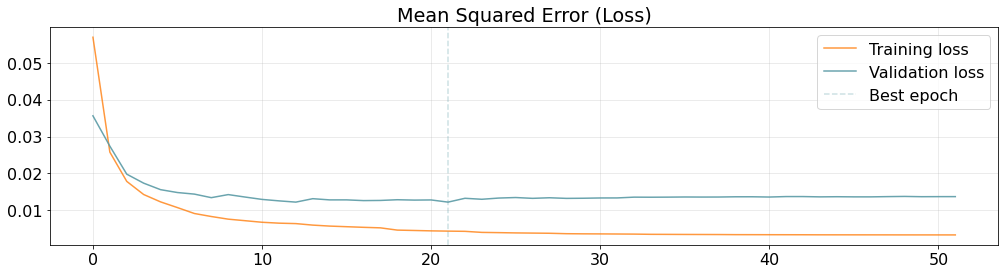

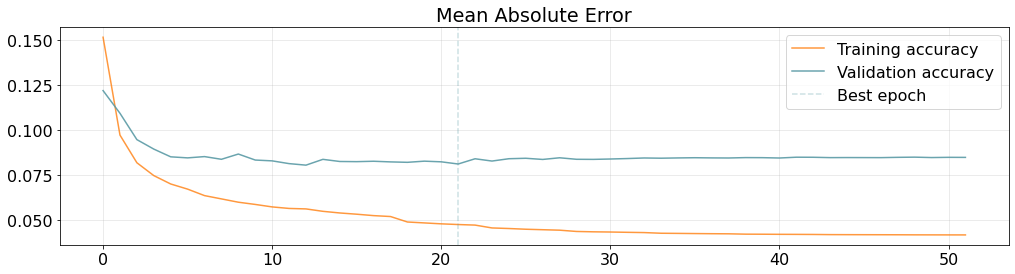

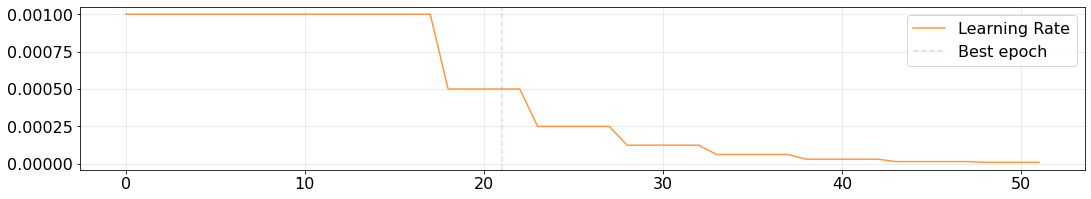

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('Models/'+title)
#model = tfk.models.load_model('Models/'+title)

In [ ]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(818, 864, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.014180688>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.087785274>)

In [ ]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

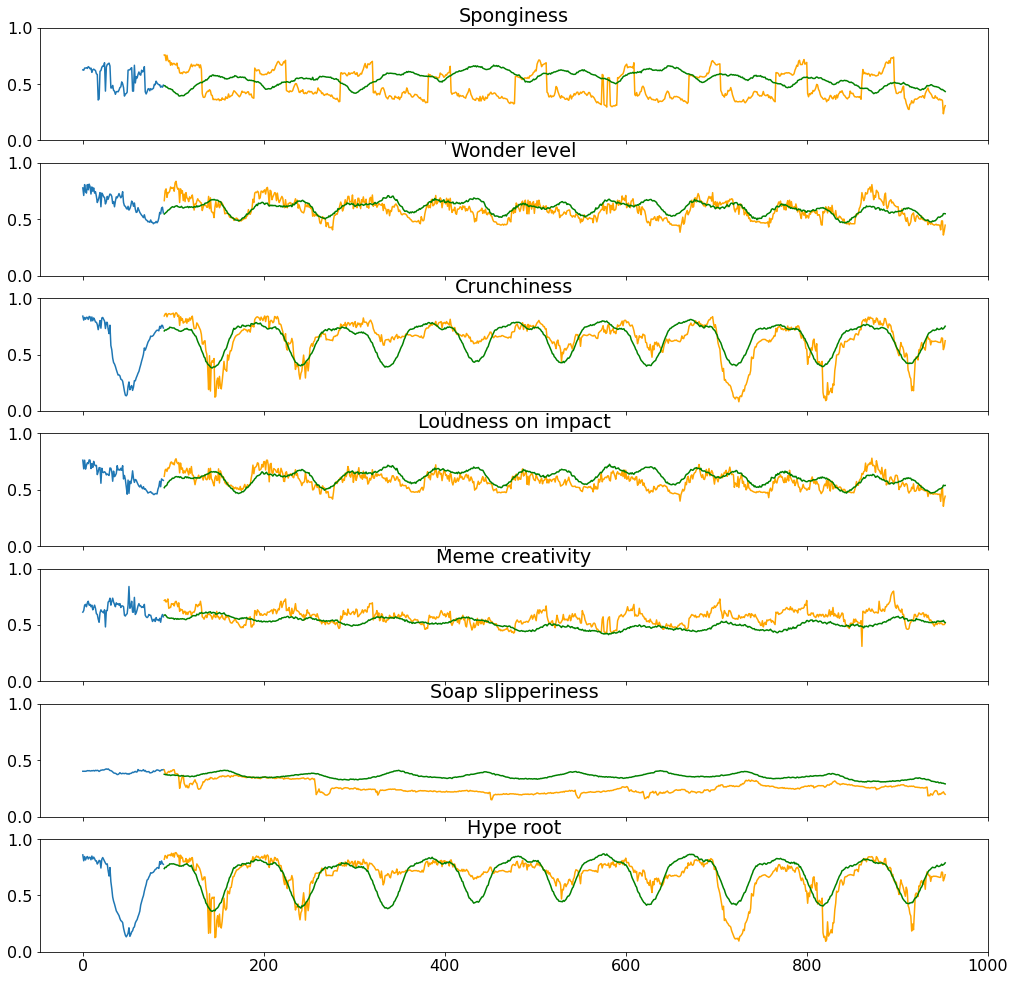

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)